# Chemical Shielding

CORY M. WIDDIFIELD, ROBERT W. SCHURKO.
"Understanding Chemical Shielding Tensors Using Group Theory, MO Analysis, and Modern Density- Functional Theory"
*Concepts in Magnetic Resonance Part A (Bridging Education and Research). (2009)
https://onlinelibrary.wiley.com/doi/pdf/10.1002/cmr.a.20136

The chemical shielding Hamiltonian:

![Hamiltonian](https://user-images.githubusercontent.com/11532812/60358602-78018d80-9a11-11e9-894f-60b8122e8a4c.png)

where gamma is the gyromagnetic ratio, I^ is the nuclear spin operator, and sigma is the magnetic shielding tensor.

In [1]:
!pip install schnetpack

     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 1.8MB 16.2MB/s 
  Stored in directory: /tmp/.cache/pip/wheels/4e/28/d3/1748daf79d0a526f1a2de70e9a3abcdb50eb01b45eeec4b786
Successfully built schnetpack


In [2]:
import numpy as np
import pandas as pd
molecules = pd.read_csv('../input/structures.csv')
molecules = molecules.groupby('molecule_name')
magnetic_shielding_tensors = pd.read_csv('../input/magnetic_shielding_tensors.csv')

In [3]:
magnetic_shielding_tensors.head(10)

,molecule_name,atom_index,XX,YX,ZX,XY,YY,ZY,XZ,YZ,ZZ
0,dsgdb9nsd_000001,0,195.3150,0.0000,-0.0001,0.0000,195.3170,0.0007,-0.0001,0.0007,195.3170
1,dsgdb9nsd_000001,1,31.3410,-1.2317,4.0544,-1.2317,28.9546,-1.7173,4.0546,-1.7173,34.0861
2,dsgdb9nsd_000001,2,31.5814,1.2173,-4.1474,1.2173,28.9036,-1.6036,-4.1476,-1.6036,33.8967
3,dsgdb9nsd_000001,3,31.5172,4.1086,1.2723,4.1088,33.9068,1.6950,1.2724,1.6951,28.9579
4,dsgdb9nsd_000001,4,31.4029,-4.0942,-1.1793,-4.0944,34.0776,1.6259,-1.1795,1.6260,28.9013
5,dsgdb9nsd_000002,0,275.6350,0.0003,0.0133,0.0003,275.6360,-0.0003,0.0161,-0.0004,237.4970
6,dsgdb9nsd_000002,1,31.2593,5.6126,-2.1025,5.6136,37.4364,-3.5567,-2.4461,-4.1372,27.9884
7,dsgdb9nsd_000002,2,31.0341,-5.4827,-2.0299,-5.4837,37.6618,3.5987,-2.3616,4.1861,27.9885
8,dsgdb9nsd_000002,3,40.7507,-0.1300,4.1318,-0.1300,27.9413,-0.0419,4.8083,-0.0488,27.9889
9,dsgdb9nsd_000003,0,310.0960,0.0000,0.0000,0.0000,355.7730,0.0000,0.0000,0.0000,324.1550


The magnetic shielding tensor:
![Magnetic shielding tensor](https://user-images.githubusercontent.com/11532812/60358839-3ae9cb00-9a12-11e9-8f3a-0236f7bc072d.png)

The symmetric portion of the shielding tensor can be diagonalized into its own principal axis system (PAS):

![PAS](https://user-images.githubusercontent.com/11532812/60359035-c95e4c80-9a12-11e9-897d-2e422e0f2e83.png)

In [4]:
x = magnetic_shielding_tensors.columns.values[2:]
x = magnetic_shielding_tensors[x].values
x = x.reshape(-1,3,3)
x = x + np.transpose(x,(0,2,1))
x = 0.5 * x
w, v = np.linalg.eigh(x)

The isotropic shielding value is defined as:

![Isotropic shielding tensor](https://user-images.githubusercontent.com/11532812/60358900-75536800-9a12-11e9-850c-654dc81fc258.png)

In [5]:
sigma_iso = np.sum(w, axis=1)/3 

![span](https://user-images.githubusercontent.com/11532812/60359189-45589480-9a13-11e9-9016-42f8a90c1ddd.png)

Ths span (Omega) describes the magnitude of the shielding anisotropy.

In [6]:
omega = w[:,2] - w[:,0]

![skew](https://user-images.githubusercontent.com/11532812/60359338-c57efa00-9a13-11e9-9619-17ebd4f44ac8.png)

The skew (kappa) describes degree of axial symmetry of the shielding tensor.

In [7]:
kappa = 3 * (sigma_iso - w[:,1])/omega

In [8]:
magnetic_shielding_parameters = magnetic_shielding_tensors[magnetic_shielding_tensors.columns.values[:2]]
magnetic_shielding_parameters = pd.DataFrame(magnetic_shielding_parameters)
magnetic_shielding_parameters["sigma_iso"] = sigma_iso
magnetic_shielding_parameters["omega"] = omega
magnetic_shielding_parameters["kappa"] = kappa

magnetic_shielding_parameters.head(10)

,molecule_name,atom_index,sigma_iso,omega,kappa
0,dsgdb9nsd_000001,0,195.316333,0.002708,0.032697
1,dsgdb9nsd_000001,1,31.460567,9.082838,0.999975
2,dsgdb9nsd_000001,2,31.460567,9.082793,0.999984
3,dsgdb9nsd_000001,3,31.460633,9.082804,0.999977
4,dsgdb9nsd_000001,4,31.460600,9.082853,0.999971
5,dsgdb9nsd_000002,0,262.922667,38.139089,-0.999939
6,dsgdb9nsd_000002,1,32.228033,15.583995,0.825251
7,dsgdb9nsd_000002,2,32.228133,15.584143,0.825259
8,dsgdb9nsd_000002,3,32.226967,15.583030,0.825318
9,dsgdb9nsd_000003,0,330.008000,45.677000,0.384417


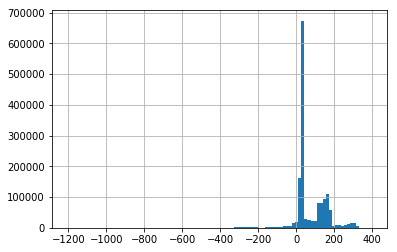

In [9]:
_ = magnetic_shielding_parameters.sigma_iso.hist(bins=100)

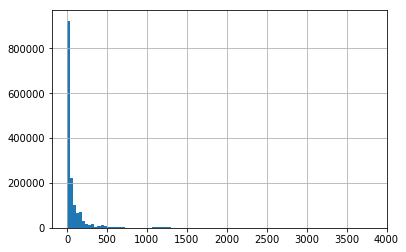

In [10]:
_ = magnetic_shielding_parameters.omega.hist(bins=100)

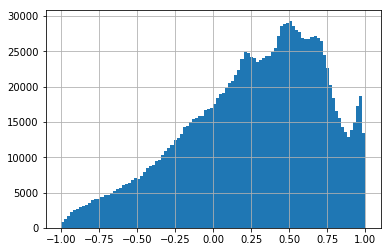

In [11]:
_ = magnetic_shielding_parameters.kappa.hist(bins=100)

Please see LibreTexts [Chemical Shift][1] if you want to understand the meaning of the parameters.

[1]: https://chem.libretexts.org/Bookshelves/Physical_and_Theoretical_Chemistry_Textbook_Maps/Supplemental_Modules_(Physical_and_Theoretical_Chemistry)/Spectroscopy/Magnetic_Resonance_Spectroscopies/Nuclear_Magnetic_Resonance/NMR%3A_Theory/NMR_Interactions/Chemical_Shift_(Shielding)

# ASE Database

In [12]:
train = pd.read_csv('../input/train.csv')
train_molecule_names = train.molecule_name.unique()

msp = magnetic_shielding_parameters.groupby('molecule_name')

In [13]:
from ase import Atoms
from ase.db import connect

def create_db(db_path, molecule_names):
    with connect(db_path) as db:
        for name in molecule_names:
            mol = molecules.get_group(name)
            atoms = Atoms(symbols=mol.atom.values,
                          positions=[(row.x,row.y,row.z) for row in mol.itertuples()])
            try:
                mol_msp = msp.get_group(name)
                sigma_iso = mol_msp['sigma_iso'].values.reshape(-1,1)
                omega = mol_msp['omega'].values.reshape(-1,1)
                kappa = mol_msp['kappa'].values.reshape(-1,1)
            except KeyError:
                sigma_iso, omega, kappa = [None] * 3
            db.write(atoms, name=name,
                     data=dict(sigma_iso=sigma_iso, omega=omega, kappa=kappa)
                    )

In [14]:
champs_path = 'CHAMPS_train.db'
dataset_size = len(train_molecule_names) # 40000
dataset_molecule_names = train_molecule_names[:dataset_size]
create_db(db_path=champs_path, molecule_names=dataset_molecule_names)

In [15]:
with connect(champs_path) as db:
    print(len(db))

85003


In [16]:
import schnetpack
dataset = schnetpack.data.AtomsData(champs_path,
                properties=['sigma_iso', 'omega', 'kappa'])

In [17]:
len(dataset)

85003

# Shielding Parameter Prediction

## SchNet Model

In [18]:
import pandas as pd

import torch
import torch.nn.functional as F
from torch.optim import Adam

import schnetpack as spk
import schnetpack.atomistic as atm
import schnetpack.representation as rep
from schnetpack.datasets import *

device = torch.device("cuda")

In [19]:
# This function comes from the following script:
# https://github.com/atomistic-machine-learning/schnetpack/blob/v0.2.1/src/scripts/schnetpack_qm9.py
def evaluate_dataset(metrics, model, loader, device):
    for metric in metrics:
        metric.reset()

    with torch.no_grad():
        for batch in loader:
            batch = {
                k: v.to(device)
                for k, v in batch.items()
            }
            result = model(batch)

            for metric in metrics:
                metric.add_batch(batch, result)

    results = [
        metric.aggregate() for metric in metrics
    ]
    return results

In [20]:
from schnetpack.data import Structure

class MagneticShielding(atm.Atomwise):
    def __init__(self, property):
        super(MagneticShielding, self).__init__(return_contributions=True)
        self.property = property
        
    def forward(self, inputs):
        result = super().forward(inputs)
        
        atom_mask = inputs[Structure.atom_mask].byte()
        
        yi = inputs[self.property]
        yi = torch.masked_select(yi.squeeze(dim=2), atom_mask)
        inputs[self.property+'_true'] = yi
        
        yi = result['yi']
        yi = torch.masked_select(yi.squeeze(dim=2), atom_mask)
        result[self.property+'_pred'] = yi
        
        return result

In [21]:
def schnet_model(property):
    reps = rep.SchNet(n_interactions=6)
    output = MagneticShielding(property=property)
    model = atm.AtomisticModel(reps, output)
    model = model.to(device)
    return model

In [22]:
def train_model(property, max_epochs=500):
    # split in train and val
    n_dataset = len(dataset)
    n_val = n_dataset // 10
    train_data, val_data, test_data = dataset.create_splits(n_dataset-n_val*2, n_val)
    train_loader = spk.data.AtomsLoader(train_data, batch_size=128, num_workers=2)
    val_loader = spk.data.AtomsLoader(val_data, batch_size=256, num_workers=2)

    # create model
    model = schnet_model(property)

    # create trainer
    target_key = property+'_true'
    output_key = property+'_pred'
    opt = Adam(model.parameters(), lr=1e-4)
    loss = lambda b, p: F.mse_loss(p[output_key], b[target_key])
    metrics = [
        spk.metrics.MeanAbsoluteError(target_key, output_key, name='MAE_'+property),
        spk.metrics.RootMeanSquaredError(target_key, output_key, name='RMSE_'+property),
    ]
    hooks = [
        spk.train.MaxEpochHook(max_epochs),
        spk.train.CSVHook(property+'/log', metrics, every_n_epochs=1),
    ]
    trainer = spk.train.Trainer(property+'/output', model, loss,
                            opt, train_loader, val_loader, hooks=hooks)

    # start training
    trainer.train(device)
    
    # evaluation
    model.load_state_dict(torch.load(property+'/output/best_model'))
    test_loader = spk.data.AtomsLoader(test_data, batch_size=256, num_workers=2)
    model.eval()

    df = pd.DataFrame()
    df['metric'] = ['MAE', 'RMSE']
    df['training'] = evaluate_dataset(metrics, model, train_loader, device)
    df['validation'] = evaluate_dataset(metrics, model, val_loader, device)
    df['test'] = evaluate_dataset(metrics, model, test_loader, device)
    display(df)
    
    return test_data

In [23]:
def show_history(property):
    df = pd.read_csv(property+'/log/log.csv')
    display(df.tail())
    max_value = None # df['RMSE_'+property].min()*5
    _ = df[['MAE_'+property,'RMSE_'+property]].plot(ylim=(0,max_value))

In [24]:
def test_prediction(dataset, property):
    # create model
    model = schnet_model(property)
    
    # load best parameters
    model.load_state_dict(torch.load(property+'/output/best_model'))
    loader = spk.data.AtomsLoader(dataset, batch_size=256, num_workers=2)
    model.eval()
    
    # predict shielding parameters
    targets = []
    predictions = []
    with torch.no_grad():
        for batch in loader:
            batch = {
                k: v.to(device)
                for k, v in batch.items()
            }
            result = model(batch)
            targets += batch[property+'_true'].tolist()
            predictions += result[property+'_pred'].tolist()
    return targets, predictions

In [25]:
def show_predictions(dataset, property):
    targets, predictions = test_prediction(dataset, property)
    df_pred = pd.DataFrame()
    df_pred['Target'] = targets
    df_pred['Prediction'] = predictions
    df_pred.plot.scatter(x='Target', y='Prediction', title=property)

## Results

sigma_iso


,metric,training,validation,test
0,MAE,2.046518,2.111925,2.116055
1,RMSE,3.731469,3.936002,4.015504


,Time,Learning rate,Train loss,Validation loss,MAE_sigma_iso,RMSE_sigma_iso
45,6043.529082,0.0001,7776.875316,16.532727,2.172407,4.065472
46,6172.649855,0.0001,7568.079619,16.549308,2.166143,4.067497
47,6302.216534,0.0001,7381.959784,16.359101,2.153676,4.044051
48,6431.600644,0.0001,7203.506982,16.051945,2.139333,4.005907
49,6562.511370,0.0001,7034.738407,15.496548,2.111925,3.936002


omega


,metric,training,validation,test
0,MAE,5.708259,5.863465,5.825453
1,RMSE,10.559502,10.936170,10.915119


,Time,Learning rate,Train loss,Validation loss,MAE_omega,RMSE_omega
45,5982.046887,0.0001,68096.943649,132.638711,6.121336,11.513058
46,6110.284701,0.0001,66448.167877,129.544911,6.046933,11.378070
47,6238.524040,0.0001,65470.753624,129.073700,6.019260,11.357393
48,6366.484609,0.0001,64346.687141,119.685873,5.863465,10.936170
49,6495.774028,0.0001,63284.275070,123.950122,5.892435,11.129769


kappa


,metric,training,validation,test
0,MAE,0.100739,0.105464,0.104602
1,RMSE,0.146245,0.153869,0.152886


,Time,Learning rate,Train loss,Validation loss,MAE_kappa,RMSE_kappa
45,5973.228064,0.0001,12.144951,0.024540,0.107687,0.156651
46,6098.157603,0.0001,12.006018,0.024314,0.107107,0.155930
47,6223.378733,0.0001,11.870471,0.024095,0.106544,0.155226
48,6347.009536,0.0001,11.738202,0.023883,0.105996,0.154539
49,6469.867298,0.0001,11.609109,0.023676,0.105464,0.153869


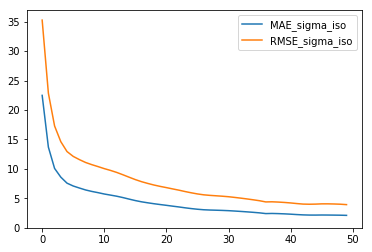

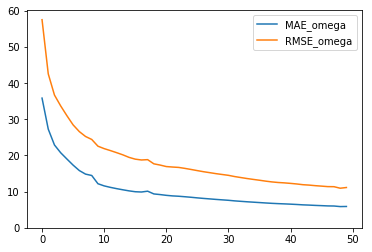

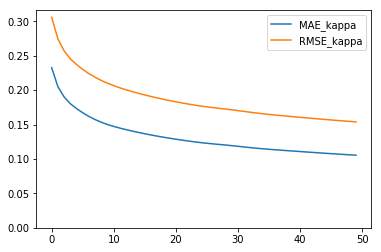

In [26]:
used_test_data = dict()
for p in ['sigma_iso', 'omega', 'kappa']:
    print(p)
    used_test_data[p] = train_model(p, max_epochs=50)
    show_history(p)

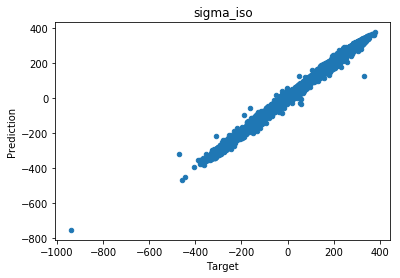

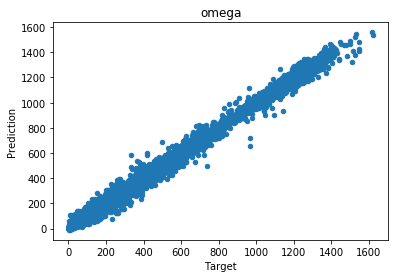

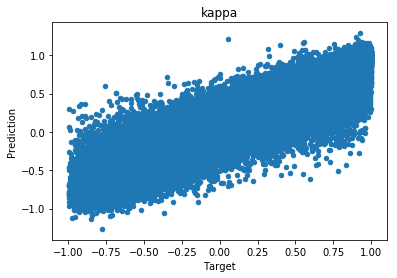

In [27]:
for p in ['sigma_iso', 'omega', 'kappa']:
    show_predictions(used_test_data[p], p)

In [28]:
!mv kappa/log/log.csv log_kappa.csv
!mv omega/log/log.csv log_omega.csv
!mv sigma_iso/log/log.csv log_sigma_iso.csv
!mv kappa/output/best_model best_model_kappa
!mv omega/output/best_model best_model_omega
!mv sigma_iso/output/best_model best_model_sigma_iso
!rm -r kappa
!rm -r omega
!rm -r sigma_iso

In [29]:
!ls

CHAMPS_train.db     best_model_kappa	  log_kappa.csv
__notebook__.ipynb  best_model_omega	  log_omega.csv
__output__.json     best_model_sigma_iso  log_sigma_iso.csv
